# SAE Latent Features vs. Graph Motifs (Configurable)

This notebook analyzes whether individual SAE latent features correspond to canonical graph motifs,
with configurable latent dimension and TopK sparsity.

In [74]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pointbiserialr
import os

import torch
import torch.nn.functional as F

from sparse_autoencoder import SparseAutoencoder

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
np.random.seed(42)
torch.manual_seed(42)

In [75]:
comparison_sae = pd.read_csv("outputs/sae_config_comparison.csv")
comparison_sae.sort_values(by = "max_rpb_abs", ascending = False)

,latent_dim,k,sparsity_pct,n_features_tested,n_active_features,dead_feature_rate,max_rpb_abs,max_rpb_feature,max_rpb_motif,best_f1,best_f1_feature,best_f1_motif,best_precision,best_recall,composite_score,description
0,256,32,12.50000,117,117,0.542969,0.475755,z247,in_feedback_loop,0.221667,z130,in_feedback_loop,1.000000,0.133,0.621893,"Medium capacity, low sparsity"
2,128,8,6.25000,35,35,0.726562,0.466303,z64,in_feedback_loop,0.213333,z95,in_feedback_loop,1.000000,0.128,0.581986,"Low capacity, high sparsity"
3,512,8,1.56250,43,43,0.916016,0.465204,z251,in_feedback_loop,0.208333,z169,in_feedback_loop,1.000000,0.125,0.550718,"High capacity, high sparsity"
1,128,16,12.50000,65,65,0.492188,0.439043,z33,in_feedback_loop,0.216667,z24,in_feedback_loop,1.000000,0.130,0.591048,"Low capacity, moderate sparsity"
5,512,16,3.12500,80,80,0.843750,0.432332,z362,in_feedback_loop,0.225000,z307,in_feedback_loop,1.000000,0.135,0.534520,"High capacity, moderate sparsity"
4,512,32,6.25000,126,126,0.753906,0.425127,z22,in_feedback_loop,0.225000,z307,in_feedback_loop,0.675000,0.135,0.540791,"High capacity, low sparsity"
8,512,4,0.78125,22,22,0.957031,0.424288,z501,in_feedback_loop,0.208333,z169,in_feedback_loop,1.000000,0.125,0.503650,"High capacity, very low sparsity"
10,256,4,1.56250,19,19,0.925781,0.408480,z125,in_feedback_loop,0.211667,z146,in_feedback_loop,0.652893,0.127,0.493696,"Medium capacity, very low sparsity"
7,128,4,3.12500,24,24,0.812500,0.407874,z38,in_feedback_loop,0.210000,z11,in_feedback_loop,0.916667,0.126,0.509499,"Low capacity, low sparsity"
9,256,8,3.12500,41,41,0.839844,0.404017,z1,in_feedback_loop,0.208333,z255,in_feedback_loop,1.000000,0.125,0.500957,"Medium capacity, high sparsity"


In [76]:
# SAE configuration (must match trained checkpoint)
INPUT_DIM = 64
LATENT_DIM = 128  # e.g., 128, 256, 512
K = 8        # e.g., 4, 8, 16, 32

# Statistical testing configuration
N_PERMUTATIONS = 1000  # Number of permutations for statistical testing
SIGNIFICANCE_LEVEL = 0.05  # FDR threshold for significance

# Construct checkpoint path based on config
checkpoint_path = f"checkpoints/sae_latent{LATENT_DIM}_k{K}.pt"

activation_dir = Path("outputs/activations/layer2_new/test")
metadata_dir = Path("virtual_graphs/data/all_graphs/graph_motif_metadata")

print("Using checkpoint:", checkpoint_path)
print(f"Permutation testing: {N_PERMUTATIONS} permutations, FDR < {SIGNIFICANCE_LEVEL}")

Using checkpoint: checkpoints/sae_latent128_k8.pt
Permutation testing: 1000 permutations, FDR < 0.05


In [77]:
# Load SAE model and test graph IDs
model = SparseAutoencoder(input_dim=INPUT_DIM, latent_dim=LATENT_DIM, k=K)
checkpoint = torch.load(checkpoint_path, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("\u2713 Loaded trained SAE model")
print(f"  Architecture: {model.input_dim} -> {model.latent_dim} -> {model.input_dim}")
print(f"  Sparsity: TopK with k={model.k} ({100*model.k/model.latent_dim:.2f}% active)")

test_graph_ids = []
for file in os.listdir("outputs/activations/layer2_new/test"):
    graph_id = int((file.split(".")[0]).split("graph_")[1])
    test_graph_ids.append(graph_id)
    
    
print(f"Number of test graphs: {len(test_graph_ids)}")

✓ Loaded trained SAE model
  Architecture: 64 -> 128 -> 64
  Sparsity: TopK with k=8 (6.25% active)
Number of test graphs: 400


In [78]:
test_graphs_ids_json = {"graph_ids":test_graph_ids}
filepath = "outputs/test_graph_ids.json"
with open(filepath, 'w') as json_file:
        json.dump(test_graphs_ids_json, json_file, indent=4)

In [79]:
# Extract SAE latent representations for all test nodes
all_latents = []  # (graph_id, node_idx, z1..z_LATENT_DIM)
all_motifs = []   # motif labels per node

print("Extracting SAE latent representations for test nodes...")
print("Reading from:", activation_dir)
print("Metadata from:", metadata_dir, "")

for graph_id in tqdm(test_graph_ids, desc="Processing test graphs"):
    act_file = activation_dir / f"graph_{graph_id}.pt"
    if not act_file.exists():
        print(f"Warning: Missing activation file for graph {graph_id}")
        continue

    activations = torch.load(act_file, weights_only=True)  # [num_nodes, 64]

    with torch.no_grad():
        latents = model.encode(activations)  # [num_nodes, LATENT_DIM]

    latents_np = latents.cpu().numpy()
    num_nodes = latents_np.shape[0]

    metadata_file = metadata_dir / f"graph_{graph_id}_metadata.csv"
    if not metadata_file.exists():
        print(f"Warning: Missing metadata for graph {graph_id}")
        continue

    df_meta = pd.read_csv(metadata_file, index_col=0)
    if len(df_meta) != num_nodes:
        print(f"Warning: Node count mismatch for graph {graph_id}: {num_nodes} vs {len(df_meta)}")
        continue

    for node_idx in range(num_nodes):
        latent_row = [graph_id, node_idx] + latents_np[node_idx].tolist()
        all_latents.append(latent_row)

        motif_row = df_meta.iloc[node_idx].to_dict()
        motif_row["graph_id"] = graph_id
        motif_row["node_idx"] = node_idx
        all_motifs.append(motif_row)

latent_cols = ["graph_id", "node_idx"] + [f"z{i+1}" for i in range(LATENT_DIM)]
df_latents = pd.DataFrame(all_latents, columns=latent_cols)
df_motifs = pd.DataFrame(all_motifs)

print(f"\u2713 Extracted latent representations for {len(df_latents)} nodes")
print(f"  Latent features shape: {df_latents.shape}")
print(f"  Motif labels shape: {df_motifs.shape}")

Extracting SAE latent representations for test nodes...
Reading from: outputs/activations/layer2_new/test
Metadata from: virtual_graphs/data/all_graphs/graph_motif_metadata 


Processing test graphs: 100%|██████████| 400/400 [00:00<00:00, 527.31it/s]

✓ Extracted latent representations for 4000 nodes
  Latent features shape: (4000, 130)
  Motif labels shape: (4000, 6)


In [80]:
non_zero_latents = set()
for i, row in df_latents.iterrows():
    latent_vals = row[2:].values
    if np.any(latent_vals != 0):
        for j, val in enumerate(latent_vals):
            if val != 0:
                non_zero_latents.add(j)

len(non_zero_latents)

26

In [81]:
# Merge latents and motifs into single dataframe
df = pd.merge(df_latents, df_motifs, on=["graph_id", "node_idx"])

motif_types = [
    "in_feedforward_loop",
    "in_feedback_loop",
    "in_single_input_module",
    "in_cascade",
]

# Standardize column names if needed
rename_map = {
    "feedforward_loop": "in_feedforward_loop",
    "feedback_loop": "in_feedback_loop",
    "single_input_module": "in_single_input_module",
    "cascade": "in_cascade",
}
for k, v in rename_map.items():
    if k in df.columns:
        df = df.rename(columns={k: v})

print("Motif distribution in test set:")
for motif in motif_types:
    if motif in df.columns:
        count = df[motif].sum()
        pct = 100 * count / len(df)
        print(f"  {motif}: {count} nodes ({pct:.2f}%)")

Motif distribution in test set:
  in_feedforward_loop: 900 nodes (22.50%)
  in_feedback_loop: 1000 nodes (25.00%)
  in_single_input_module: 896 nodes (22.40%)
  in_cascade: 800 nodes (20.00%)


In [82]:
# 3. Point-biserial correlation analysis
latent_features = [f"z{i+1}" for i in range(LATENT_DIM)]

correlations = []
print("Computing point-biserial correlations...")

for motif in motif_types:
    if motif not in df.columns:
        continue
    for z_idx, z_col in enumerate(latent_features):
        corr, pval = pointbiserialr(df[motif], df[z_col])
        correlations.append({
            "feature": z_col,
            "feature_idx": z_idx + 1,
            "motif": motif,
            "rpb": corr,
            "pval": pval,
            "rpb_abs": abs(corr),
        })

df_corr = pd.DataFrame(correlations)
print(f"\u2713 Computed {len(df_corr)} correlations ({len(latent_features)} features \u00d7 {len(motif_types)} motifs)")
print("Correlation statistics:")
print(df_corr[["rpb", "rpb_abs", "pval"]].describe())

corr_matrix = df_corr.pivot(index="feature", columns="motif", values="rpb")
corr_matrix.to_csv("outputs/feature_motif_correlations_configurable.csv")
print("\u2713 Saved correlation matrix to outputs/feature_motif_correlations_configurable.csv")

Computing point-biserial correlations...


/data/users/goodarzilab/shervin/miniconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5655: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


✓ Computed 512 correlations (128 features × 4 motifs)
Correlation statistics:
              rpb     rpb_abs           pval
count  104.000000  104.000000   1.040000e+02
mean     0.010089    0.089314   2.206591e-01
std      0.129300    0.093631   3.146493e-01
min     -0.284754    0.000353  5.166889e-132
25%     -0.041089    0.010207   1.767222e-24
50%     -0.007549    0.041467   8.794731e-03
75%      0.041934    0.160468   5.187235e-01
max      0.372677    0.372677   9.822095e-01
✓ Saved correlation matrix to outputs/feature_motif_correlations_configurable.csv


## 4. Permutation Testing for Statistical Significance

To determine if observed correlations are statistically significant (not due to chance), we perform permutation testing:

1. **Null Hypothesis**: Feature activations are independent of motif labels
2. **Test Statistic**: Point-biserial correlation (rpb)
3. **Null Distribution**: Shuffle motif labels 1000 times, recompute correlations each time
4. **P-value**: Fraction of permutations where |rpb_permuted| ≥ |rpb_observed|
5. **Multiple Testing Correction**: Benjamini-Hochberg FDR to control false discovery rate at α=0.05

In [83]:
# Permutation testing
print(f"Running permutation test with {N_PERMUTATIONS} permutations...")
print("This will take a few minutes...\n")

# Store null distributions for each feature-motif pair
null_distributions = {motif: {f: [] for f in latent_features} for motif in motif_types}

for perm_idx in tqdm(range(N_PERMUTATIONS), desc="Permutations"):
    for motif in motif_types:
        # Shuffle motif labels
        shuffled_labels = df[motif].sample(frac=1, random_state=42+perm_idx).reset_index(drop=True)
        
        # Compute correlations with shuffled labels
        for z_col in latent_features:
            if df[z_col].std() == 0:  # Skip constant features
                continue
            corr_perm, _ = pointbiserialr(shuffled_labels, df[z_col])
            null_distributions[motif][z_col].append(corr_perm)

# Calculate empirical p-values
df_corr['p_empirical'] = 1.0
df_corr['p_directional'] = 1.0

for idx, row in df_corr.iterrows():
    feature = row['feature']
    motif = row['motif']
    obs_rpb = row['rpb']
    obs_rpb_abs = abs(obs_rpb)
    
    null_dist = null_distributions[motif][feature]
    if len(null_dist) == 0:
        continue
    
    # Two-tailed: count how many null values have |rpb| >= observed
    p_empirical = (np.abs(null_dist) >= obs_rpb_abs).sum() / N_PERMUTATIONS
    df_corr.loc[idx, 'p_empirical'] = p_empirical
    
    # One-tailed directional test
    if obs_rpb > 0:
        p_directional = (np.array(null_dist) >= obs_rpb).sum() / N_PERMUTATIONS
    else:
        p_directional = (np.array(null_dist) <= obs_rpb).sum() / N_PERMUTATIONS
    df_corr.loc[idx, 'p_directional'] = p_directional

# Multiple testing correction
from statsmodels.stats.multitest import multipletests

# Bonferroni correction
df_corr['p_bonferroni'] = df_corr['p_empirical'] * len(df_corr)
df_corr['p_bonferroni'] = df_corr['p_bonferroni'].clip(upper=1.0)

# FDR correction (Benjamini-Hochberg)
reject, pvals_fdr, _, _ = multipletests(df_corr['p_empirical'], alpha=SIGNIFICANCE_LEVEL, method='fdr_bh')
df_corr['p_fdr'] = pvals_fdr
df_corr['significant_fdr'] = reject

# Print results
n_significant = df_corr['significant_fdr'].sum()
print(f"\n✓ Permutation testing complete")
print(f"  Significant feature-motif pairs (FDR < {SIGNIFICANCE_LEVEL}): {n_significant}/{len(df_corr)}")
print(f"\nSignificance summary:")
print(df_corr[df_corr['significant_fdr']].nlargest(10, 'rpb_abs')[['feature', 'motif', 'rpb', 'p_empirical', 'p_fdr']])

Running permutation test with 1000 permutations...
This will take a few minutes...



Permutations: 100%|██████████| 1000/1000 [02:10<00:00,  7.68it/s]


✓ Permutation testing complete
  Significant feature-motif pairs (FDR < 0.05): 50/512

Significance summary:
    feature             motif       rpb  p_empirical  p_fdr
213     z86  in_feedback_loop  0.372677          0.0    0.0
215     z88  in_feedback_loop  0.289785          0.0    0.0
166     z39  in_feedback_loop  0.287928          0.0    0.0
240    z113  in_feedback_loop -0.284754          0.0    0.0
138     z11  in_feedback_loop  0.270426          0.0    0.0
207     z80  in_feedback_loop -0.270266          0.0    0.0
193     z66  in_feedback_loop  0.256943          0.0    0.0
176     z49  in_feedback_loop  0.252779          0.0    0.0
153     z26  in_feedback_loop  0.252050          0.0    0.0
252    z125  in_feedback_loop  0.249200          0.0    0.0


## 5. Precision and Recall Analysis

$$\text{Precision} = \frac{\#\text{ nodes where } (z_j > \tau) \text{ and motif present}}{\#\text{ nodes where } (z_j > \tau)}$$

$$\text{Recall} = \frac{\#\text{ nodes where } (z_j > \tau) \text{ and motif present}}{\#\text{ nodes with motif present}}$$

where $\tau$ is the 95th percentile activation threshold.

In [85]:
def compute_precision_recall(df, feature, motif, percentile=95):
    """Compute precision and recall for a feature-motif pair."""
    # Threshold at specified percentile
    threshold = np.percentile(df[feature], percentile)
    
    # Nodes where feature is highly activated
    activated = df[feature] > threshold
    
    # Nodes where motif is present
    present = df[motif] == 1
    
    # True positives
    tp = (activated & present).sum()
    
    # Precision and recall
    precision = tp / activated.sum() if activated.sum() > 0 else 0
    recall = tp / present.sum() if present.sum() > 0 else 0
    
    return precision, recall, threshold

# Compute precision/recall for top correlated features
precision_recall_results = []

print("Computing precision and recall for top features...")

# For each motif, get top 10 features by absolute correlation
for motif in motif_types:
    if motif not in df.columns:
        continue
    
    motif_corrs = df_corr[df_corr['motif'] == motif].nlargest(10, 'rpb_abs')
    
    for _, row in motif_corrs.iterrows():
        feature = row['feature']
        precision, recall, threshold = compute_precision_recall(df, feature, motif)
        
        precision_recall_results.append({
            'feature': feature,
            'motif': motif,
            'rpb': row['rpb'],
            'precision': precision,
            'recall': recall,
            'threshold': threshold,
            'f1_score': 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        })

df_pr = pd.DataFrame(precision_recall_results)

print(f"\n✓ Computed precision/recall for {len(df_pr)} feature-motif pairs")
print(f"\nPrecision/Recall statistics:")
print(df_pr[['precision', 'recall', 'f1_score']].describe())

print(f"\nTop 10 by F1 score:")
print(df_pr.nlargest(10, 'f1_score')[['feature', 'motif', 'rpb', 'precision', 'recall', 'f1_score']])

Computing precision and recall for top features...

✓ Computed precision/recall for 40 feature-motif pairs

Precision/Recall statistics:
       precision     recall   f1_score
count  40.000000  40.000000  40.000000
mean    0.260778   0.055039   0.090580
std     0.219656   0.044938   0.074712
min     0.000000   0.000000   0.000000
25%     0.133523   0.026583   0.043674
50%     0.180000   0.043750   0.070000
75%     0.423750   0.094587   0.154653
max     0.650000   0.130000   0.216667

Top 10 by F1 score:
   feature                   motif       rpb  precision    recall  f1_score
10     z86        in_feedback_loop  0.372677      0.650  0.130000  0.216667
17     z49        in_feedback_loop  0.252779      0.645  0.129000  0.215000
14     z11        in_feedback_loop  0.270426      0.635  0.127000  0.211667
12     z39        in_feedback_loop  0.287928      0.630  0.126000  0.210000
19    z125        in_feedback_loop  0.249200      0.630  0.126000  0.210000
18     z26        in_feedback_loop 

In [86]:
sig_corr_fdr = df_corr[df_corr['significant_fdr'] == True]
",".join(list(sig_corr_fdr['feature'].unique()))

'z64,z80,z88,z97,z11,z25,z26,z33,z38,z39,z49,z53,z54,z66,z72,z82,z86,z89,z93,z98,z113,z125,z128'

In [87]:
df_corr.to_csv("outputs/latent_correlations.csv")

In [88]:
df_corr = pd.read_csv("outputs/latent_correlations.csv")
sig_corr = df_corr[df_corr["significant_fdr"] == True]
sig_corr["motif"].value_counts()

motif
in_feedback_loop          23
in_single_input_module    22
in_feedforward_loop        4
in_cascade                 1
Name: count, dtype: int64

In [99]:
df_corr[(df_corr["significant_fdr"] == True) & (df_corr["rpb_abs"] >= 0.15)]["motif"].value_counts()

motif
in_feedback_loop          17
in_single_input_module    13
Name: count, dtype: int64

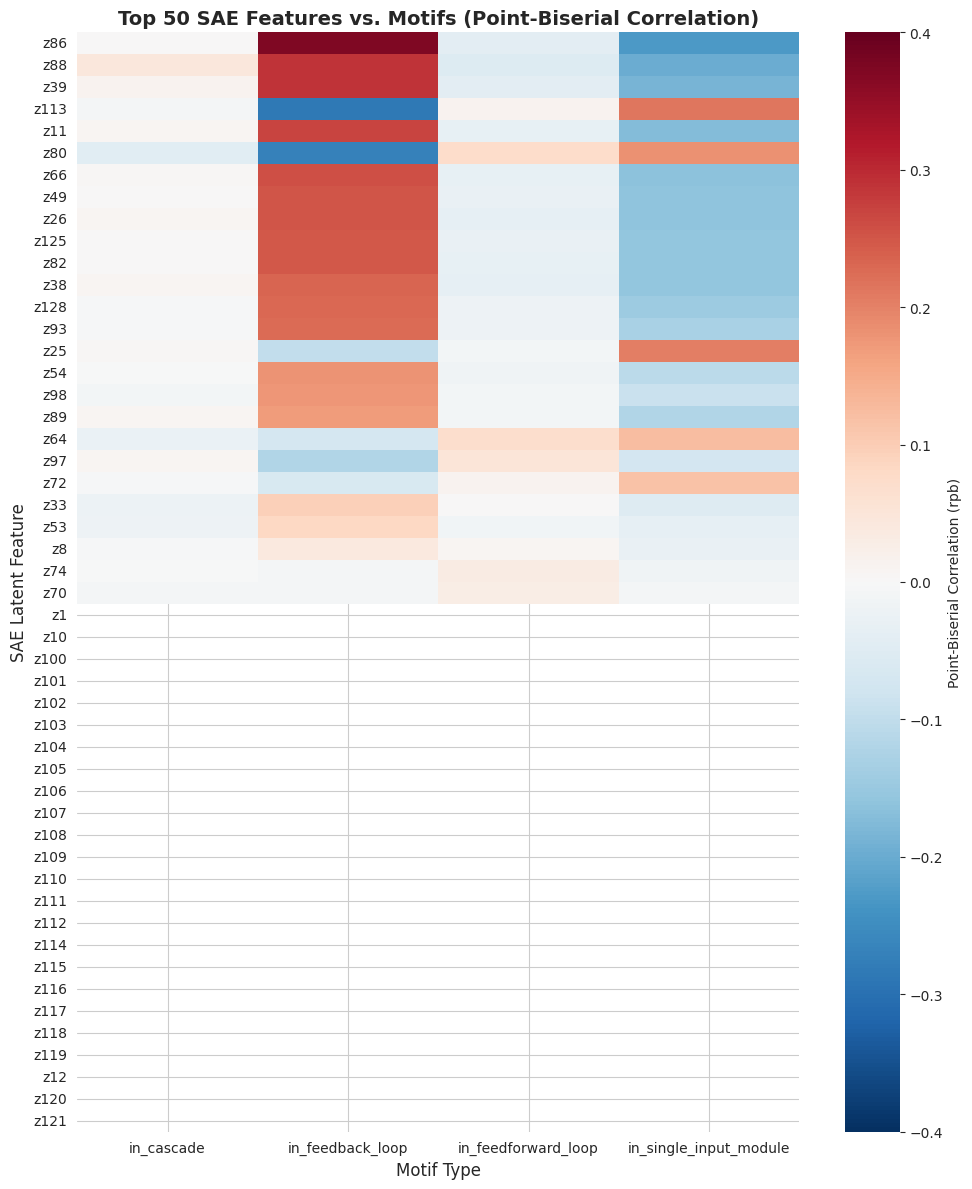

In [90]:
# Plot 1: Correlation heatmap for top features
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Get top 50 features by max absolute correlation
max_corrs = corr_matrix.abs().max(axis=1)
top_features = max_corrs.nlargest(50).index

# Plot heatmap
sns.heatmap(corr_matrix.loc[top_features], 
            cmap='RdBu_r', center=0, vmin=-0.4, vmax=0.4,
            cbar_kws={'label': 'Point-Biserial Correlation (rpb)'},
            ax=ax)
ax.set_title('Top 50 SAE Features vs. Motifs (Point-Biserial Correlation)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Motif Type', fontsize=12)
ax.set_ylabel('SAE Latent Feature', fontsize=12)

plt.tight_layout()
plt.savefig('outputs/paper_figures/feature_motif_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

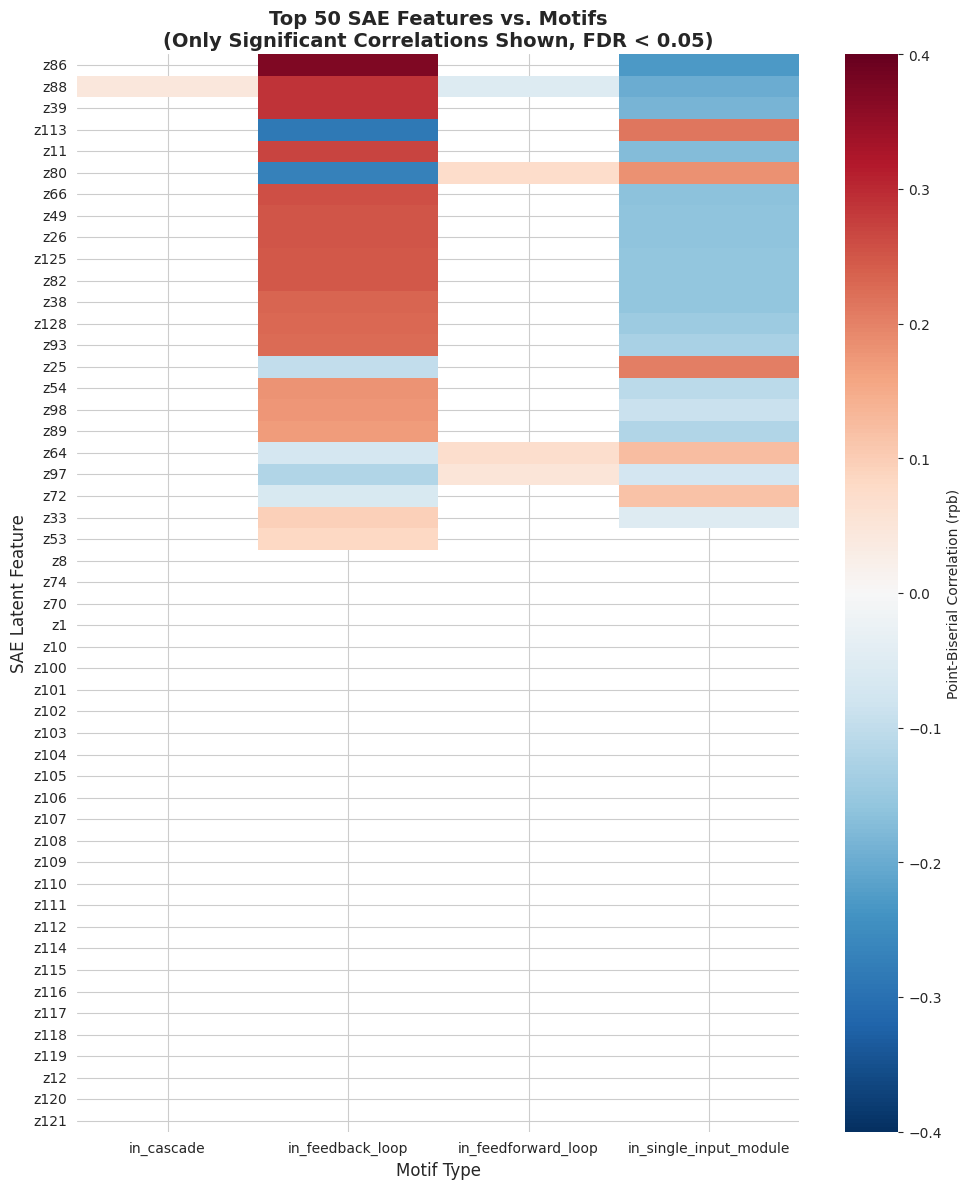

In [92]:
# Plot 1: Correlation heatmap for top features (with significance masking)
fig, ax = plt.subplots(1, 1, figsize=(10, 12))

# Get top 50 features by max absolute correlation
max_corrs = corr_matrix.abs().max(axis=1)
top_features = max_corrs.nlargest(50).index

# Create significance mask
sig_matrix = df_corr.pivot(index='feature', columns='motif', values='significant_fdr')
mask = ~sig_matrix.loc[top_features].fillna(False)  # Mask non-significant

# Plot heatmap
sns.heatmap(corr_matrix.loc[top_features], 
            mask=mask,
            cmap='RdBu_r', center=0, vmin=-0.4, vmax=0.4,
            cbar_kws={'label': 'Point-Biserial Correlation (rpb)'},
            ax=ax)
ax.set_title('Top 50 SAE Features vs. Motifs\n(Only Significant Correlations Shown, FDR < 0.05)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Motif Type', fontsize=12)
ax.set_ylabel('SAE Latent Feature', fontsize=12)

plt.tight_layout()
plt.savefig('outputs/paper_figures/feature_motif_correlation_heatmap_significant.png', dpi=150, bbox_inches='tight')
plt.show()

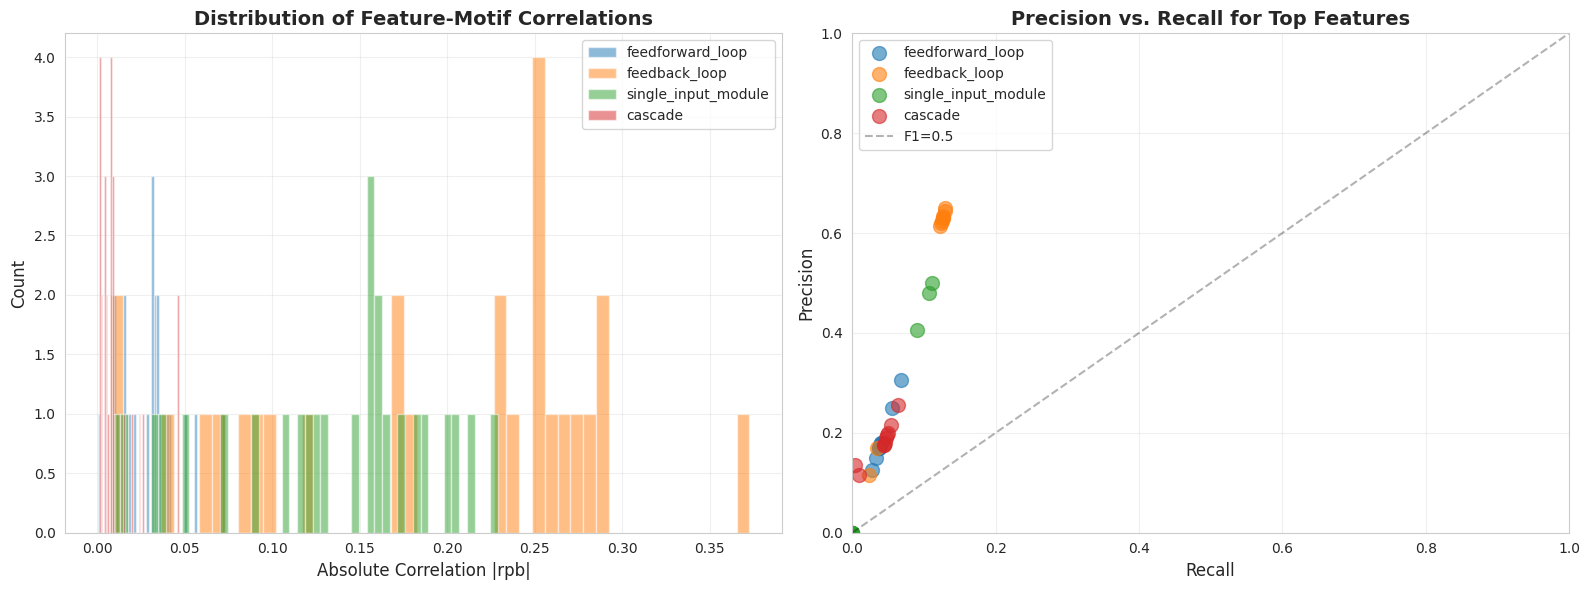

In [93]:
# Plot 2: Distribution of correlation strengths
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Histogram of absolute correlations
ax = axes[0]
for motif in motif_types:
    if motif in df_corr['motif'].values:
        motif_corrs = df_corr[df_corr['motif'] == motif]['rpb_abs']
        ax.hist(motif_corrs, bins=50, alpha=0.5, label=motif.replace('in_', ''))

ax.set_xlabel('Absolute Correlation |rpb|', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Feature-Motif Correlations', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Right: Precision vs Recall scatter
ax = axes[1]
for motif in motif_types:
    motif_pr = df_pr[df_pr['motif'] == motif]
    ax.scatter(motif_pr['recall'], motif_pr['precision'], 
              alpha=0.6, s=100, label=motif.replace('in_', ''))

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='F1=0.5')
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision vs. Recall for Top Features', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('outputs/paper_figures/correlation_distribution_and_precision_recall.png', dpi=150, bbox_inches='tight')
plt.show()

In [94]:
df_corr

,Unnamed: 0,feature,feature_idx,motif,rpb,pval,rpb_abs,p_empirical,p_directional,p_bonferroni,p_fdr,significant_fdr
0,0,z1,1,in_feedforward_loop,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
1,1,z2,2,in_feedforward_loop,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
2,2,z3,3,in_feedforward_loop,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
3,3,z4,4,in_feedforward_loop,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
4,4,z5,5,in_feedforward_loop,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
507,507,z124,124,in_cascade,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
508,508,z125,125,in_cascade,0.001749,0.911926,0.001749,0.917,0.454,1.0,1.0,False
509,509,z126,126,in_cascade,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
510,510,z127,127,in_cascade,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False


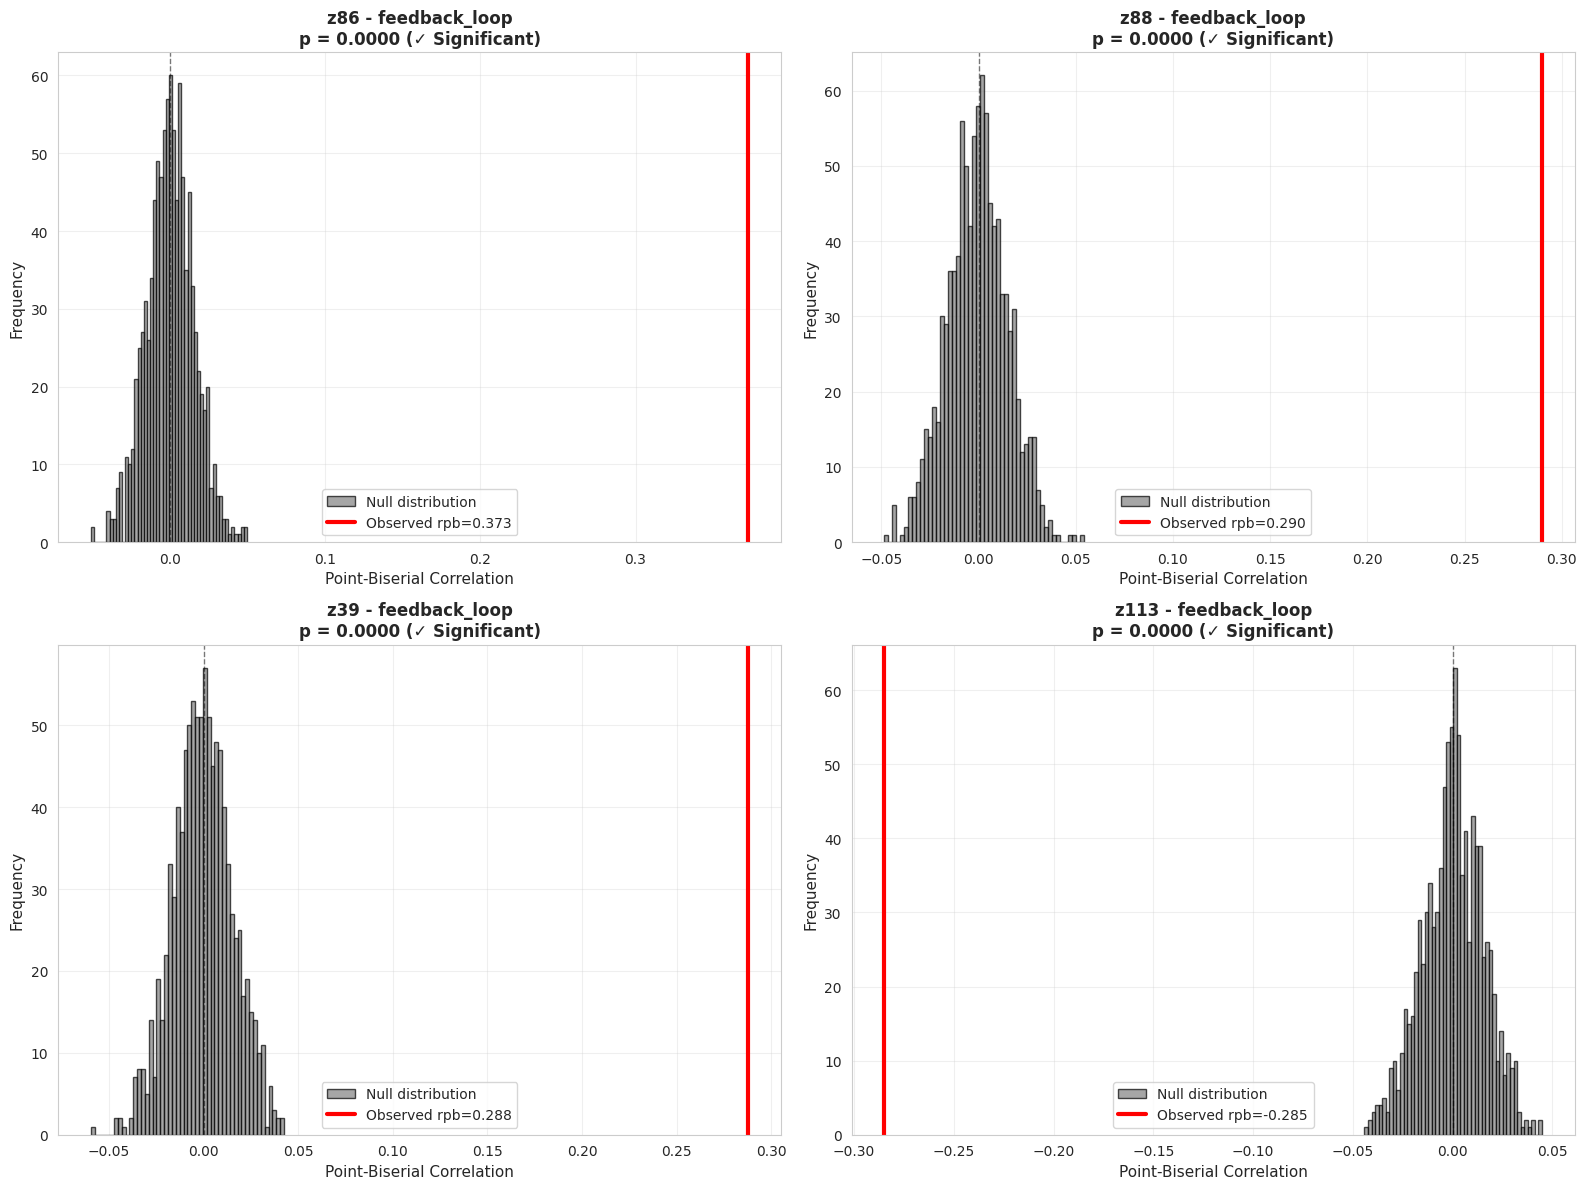

In [95]:
# Plot 4: Null distributions for top significant features
top_significant = df_corr[df_corr['significant_fdr']].nlargest(4, 'rpb_abs') if df_corr['significant_fdr'].any() else df_corr.nlargest(4, 'rpb_abs')

if len(top_significant) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    
    for idx, (_, row) in enumerate(top_significant.iterrows()):
        if idx >= 4:
            break
        
        ax = axes[idx]
        feature = row['feature']
        motif = row['motif']
        obs_rpb = row['rpb']
        p_val = row['p_empirical']
        is_sig = row['significant_fdr']
        
        # Get null distribution
        null_dist = null_distributions[motif][feature]
        
        # Plot histogram
        ax.hist(null_dist, bins=50, alpha=0.7, color='gray', edgecolor='black', label='Null distribution')
        ax.axvline(obs_rpb, color='red', linewidth=3, label=f'Observed rpb={obs_rpb:.3f}')
        ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        
        ax.set_xlabel('Point-Biserial Correlation', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        sig_str = '✓ Significant' if is_sig else 'Not significant'
        ax.set_title(f'{feature} - {motif.replace("in_", "")}\np = {p_val:.4f} ({sig_str})',
                     fontsize=12, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('outputs/paper_figures/null_distributions_top_features.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No feature-motif pairs to visualize.")

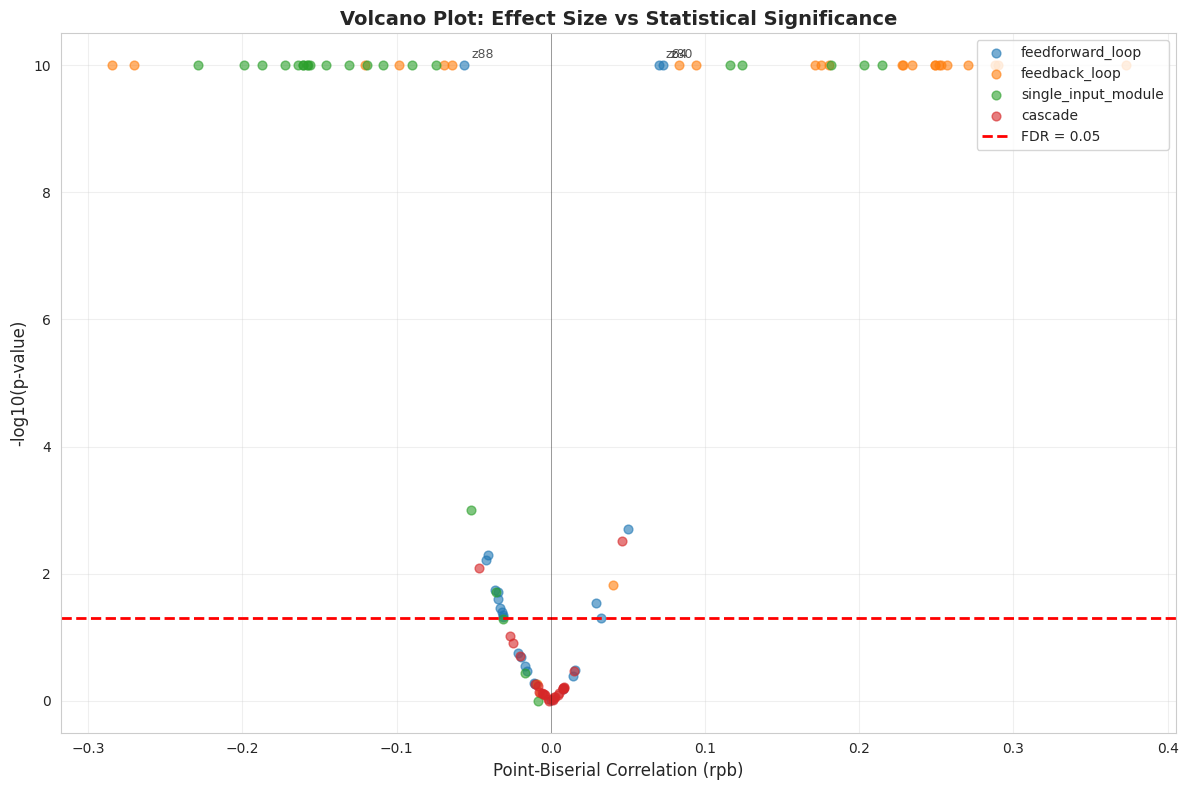

In [96]:
# Plot 5: Volcano plot (effect size vs significance)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot all feature-motif pairs
for motif in motif_types:
    motif_data = df_corr[df_corr['motif'] == motif]
    # Avoid log(0) by adding small epsilon
    neg_log_p = -np.log10(motif_data['p_empirical'].replace(0, 1e-10))
    
    ax.scatter(motif_data['rpb'], neg_log_p, 
              alpha=0.6, s=40, label=motif.replace('in_', ''))

# Add significance threshold line
sig_threshold = -np.log10(SIGNIFICANCE_LEVEL)
ax.axhline(y=sig_threshold, color='red', linestyle='--', 
           linewidth=2, label=f'FDR = {SIGNIFICANCE_LEVEL}')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

ax.set_xlabel('Point-Biserial Correlation (rpb)', fontsize=12)
ax.set_ylabel('-log10(p-value)', fontsize=12)
ax.set_title('Volcano Plot: Effect Size vs Statistical Significance', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)

# Annotate top significant features
top_anno = df_corr[df_corr['significant_fdr']].nsmallest(3, 'p_empirical') if df_corr['significant_fdr'].any() else pd.DataFrame()
for _, row in top_anno.iterrows():
    ax.annotate(f"{row['feature']}", 
                xy=(row['rpb'], -np.log10(max(row['p_empirical'], 1e-10))),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)

plt.tight_layout()
plt.savefig('outputs/paper_figures/volcano_plot.png', dpi=150, bbox_inches='tight')
plt.show()

In [97]:
df_corr

,Unnamed: 0,feature,feature_idx,motif,rpb,pval,rpb_abs,p_empirical,p_directional,p_bonferroni,p_fdr,significant_fdr
0,0,z1,1,in_feedforward_loop,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
1,1,z2,2,in_feedforward_loop,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
2,2,z3,3,in_feedforward_loop,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
3,3,z4,4,in_feedforward_loop,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
4,4,z5,5,in_feedforward_loop,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
507,507,z124,124,in_cascade,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
508,508,z125,125,in_cascade,0.001749,0.911926,0.001749,0.917,0.454,1.0,1.0,False
509,509,z126,126,in_cascade,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False
510,510,z127,127,in_cascade,NaN,NaN,NaN,1.000,1.000,1.0,1.0,False


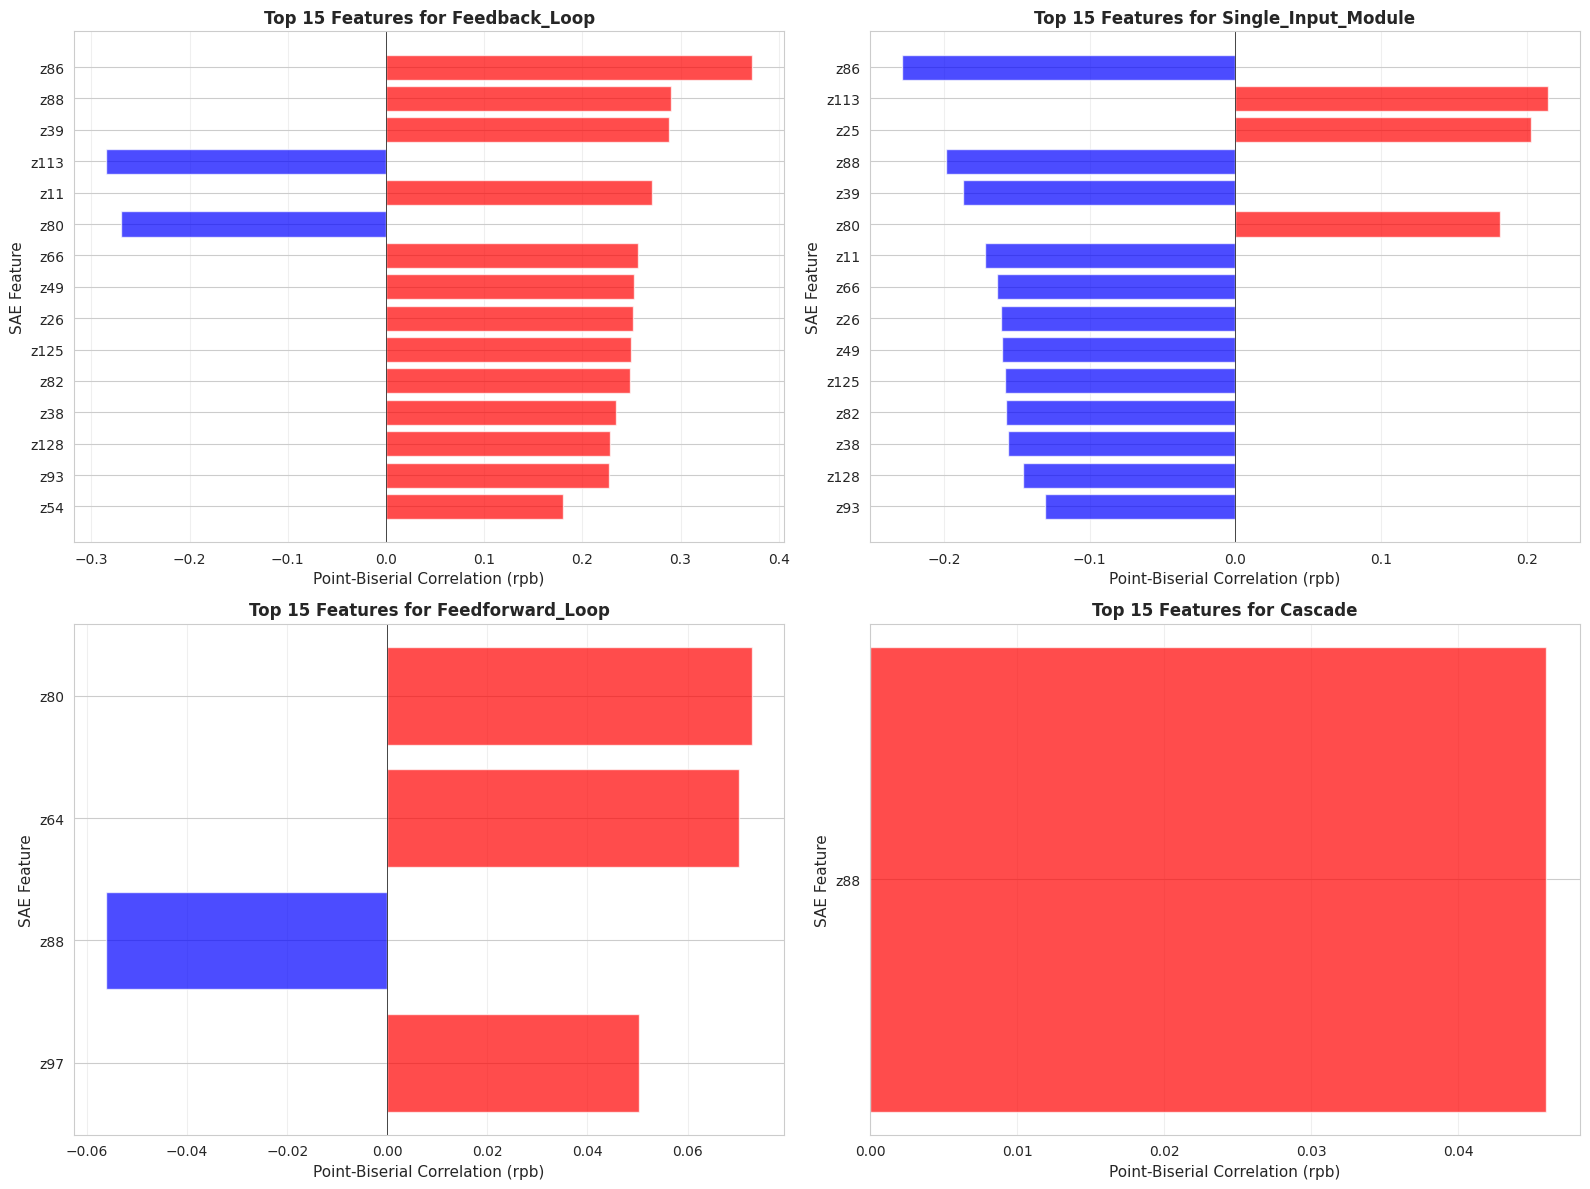

In [98]:
# Plot 6: Top features for each motif type
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()
df_corr_sig = df_corr[df_corr['significant_fdr'] == True]

for idx, motif in enumerate(["in_feedback_loop", "in_single_input_module", "in_feedforward_loop", "in_cascade"]):
    ax = axes[idx]
    # Get top 15 features for this motif
    motif_corrs = df_corr_sig[df_corr_sig['motif'] == motif].nlargest(15, 'rpb_abs')
    # Create bar plot
    colors = ['red' if rpb > 0 else 'blue' for rpb in motif_corrs['rpb']]
    ax.barh(range(len(motif_corrs)), motif_corrs['rpb'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(motif_corrs)))
    ax.set_yticklabels(motif_corrs['feature'])
    ax.set_xlabel('Point-Biserial Correlation (rpb)', fontsize=11)
    ax.set_ylabel('SAE Feature', fontsize=11)
    ax.set_title(f'Top 15 Features for {motif.replace("in_", "").title()}', 
                 fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('outputs/paper_figures/top_features_per_motif.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Conclusions

This analysis evaluated whether SAE latent features correspond to canonical graph motifs using:

1. **Point-biserial correlation** - Measures linear association between continuous feature activation and binary motif presence
2. **Permutation testing** - Assesses statistical significance by comparing observed correlations to a null distribution generated from 1000 random permutations of motif labels  
3. **Multiple testing correction** - Controls false discovery rate (FDR) at 5% using the Benjamini-Hochberg procedure to account for testing multiple feature-motif pairs
4. **Precision/Recall** - Evaluates predictive performance when using high feature activation (>95th percentile) as a predictor of motif presence

**Interpretation:**
The permutation testing framework provides rigorous statistical evidence for feature-motif associations. Features with significant correlations (after FDR correction) show associations that are unlikely to occur by chance alone. However, the strength of these correlations and their predictive performance should be considered when interpreting biological relevance.

The analysis reveals whether the SAE successfully learned to decompose GNN representations into interpretable, motif-specific features or whether the latent space encodes graph structure in a more distributed, entangled manner.